# Creating and Valuing a CDS Option

Example CDS Valuation and comparison with market standard ISDA model on Markit website

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.utils import *
from financepy.products.rates import *
from financepy.products.credit import *

####################################################################
# FINANCEPY BETA Version 0.185 - This build:  24 Oct 2020 at 20:12 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy  #
#      Send any bug reports or comments to quant@financepy.com     #
####################################################################



Set the trade date and settlement date one day later

In [3]:
valuation_date = Date(5, 2, 2014)
settlement_date = valuation_date.add_days(1)

## Build Ibor Curve

In [6]:
dcType = DayCountTypes.THIRTY_E_360
depo = IborDeposit(settlement_date, "1D", 0.0502, dcType)
depos = [depo]
fixedFreq = FrequencyTypes.SEMI_ANNUAL
swapType = SwapTypes.PAY
swap1 = IborSwap(settlement_date,"1Y",swapType,0.0502,fixedFreq,dcType)
swap2 = IborSwap(settlement_date,"2Y",swapType,0.0502,fixedFreq,dcType)
swap3 = IborSwap(settlement_date,"3Y",swapType,0.0501,fixedFreq,dcType)
swap4 = IborSwap(settlement_date,"4Y",swapType,0.0502,fixedFreq,dcType)
swap5 = IborSwap(settlement_date,"5Y",swapType,0.0501,fixedFreq,dcType)
swaps = [swap1,swap2,swap3,swap4,swap5]

libor_curve = FinIborSingleCurve(valuation_date, depos, [], swaps)

Inserting synthetic deposit


## Build a CDS Curve

In [7]:
cdsFlatSpread = 0.0100

In [8]:
cds1 = FinCDS(settlement_date, "1Y", cdsFlatSpread)
cds2 = FinCDS(settlement_date, "2Y", cdsFlatSpread)
cds3 = FinCDS(settlement_date, "3Y", cdsFlatSpread)
cds4 = FinCDS(settlement_date, "4Y", cdsFlatSpread)
cds5 = FinCDS(settlement_date, "5Y", cdsFlatSpread)
cds6 = FinCDS(settlement_date, "7Y", cdsFlatSpread)
cds7 = FinCDS(settlement_date, "10Y", cdsFlatSpread)
cds8 = FinCDS(settlement_date, "15Y", cdsFlatSpread)

In [9]:
cdss = [cds1, cds2, cds3, cds4, cds5, cds6, cds7, cds8]

In [10]:
recovery_rate = 0.40

In [11]:
issuer_curve = FinCDSCurve(valuation_date, cdss, libor_curve, recovery_rate)

## CDS Option

In [13]:
step_in_date = valuation_date.add_days(1)
expiry_date = Date(20, 3, 2014)
maturity_date = Date(20, 6, 2019)    

In [14]:
cdsCoupon = 0.01
volatility = 0.3    
notional = ONE_MILLION
long_protection = True

In [15]:
strikes = np.linspace(80,120,21)/10000
longValues = []
shortValues = []

# Long Protection
for strike in strikes:
    cdsOption = FinCDSOption(expiry_date, maturity_date, strike, notional, True)
    v = cdsOption.value(valuation_date, issuer_curve, volatility)
    longValues.append(v)
    
# Short Protection
for strike in strikes:
    cdsOption = FinCDSOption(expiry_date, maturity_date, strike, notional, False)
    v = cdsOption.value(valuation_date, issuer_curve, volatility)
    shortValues.append(v)
    

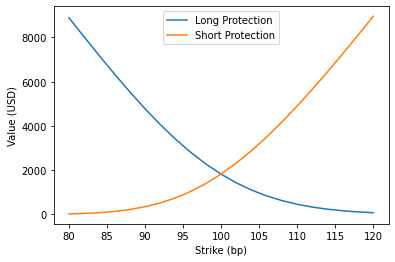

In [16]:
plt.plot(strikes*10000, longValues, label="Long Protection")
plt.plot(strikes*10000, shortValues, label="Short Protection")
plt.xlabel("Strike (bp)")
plt.ylabel("Value (USD)")
plt.legend();

## Put Call Parity

Check that put-call parity holds by comparing a long protection minus a short protection option to a forward starting long protection CDS

In [17]:
fwdValues = []

for strike in strikes:
    fwdCDSContract = FinCDS(expiry_date, maturity_date, strike, notional, True)
    v = fwdCDSContract.value(valuation_date, issuer_curve, recovery_rate)
    fwdValues.append(v['full_pv'])

In [18]:
callMinusPut = np.array(longValues) - np.array(shortValues)

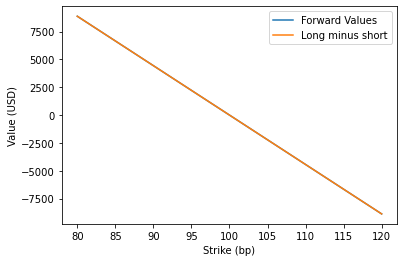

In [20]:
plt.plot(strikes*10000, fwdValues, label="Forward Values")
plt.plot(strikes*10000, callMinusPut, label="Long minus short")
plt.xlabel("Strike (bp)")
plt.ylabel("Value (USD)")
plt.legend();

## Implied Volatility

Let us just check that we can recover the input volatility

In [21]:
for strike in np.linspace(100, 200, 21):
    cdsOption = FinCDSOption(expiry_date, maturity_date, strike / 10000.0,  notional, False)
    v = cdsOption.value(valuation_date, issuer_curve, volatility)
    vol = cdsOption.implied_volatility(valuation_date, issuer_curve, v)
    print("%10d %12.5f %12.8f%%" %(strike, v, vol*100))

       100   1825.04151  30.00000000%
       105   3186.75629  30.00000000%
       110   4901.42375  30.00000000%
       115   6859.25130  30.00000000%
       120   8958.29214  30.00000000%
       125  11127.95456  30.00000000%
       130  13328.59731  30.00000000%
       135  15541.35112  30.00000000%
       140  17758.38211  30.00000000%
       145  19976.79407  30.00000000%
       150  22195.61792  30.00000000%
       155  24414.55631  30.00000000%
       160  26633.52463  30.00000000%
       165  28852.50036  30.00000000%
       170  31071.47783  30.00000000%
       175  33290.45570  30.00000000%
       180  35509.43365  30.00000000%
       185  37728.41162  30.00000000%
       190  39947.38959  30.00000000%
       195  42166.36756  30.00000000%
       200  44385.34554  30.00000000%


We recovery the used volatility as required.

Copyright (c) 2020 Dominic O'Kane